# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**____________

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#from keras.models import Sequential
#from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

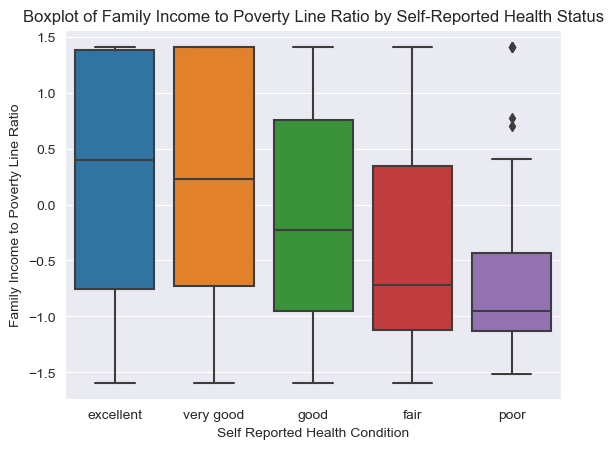

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

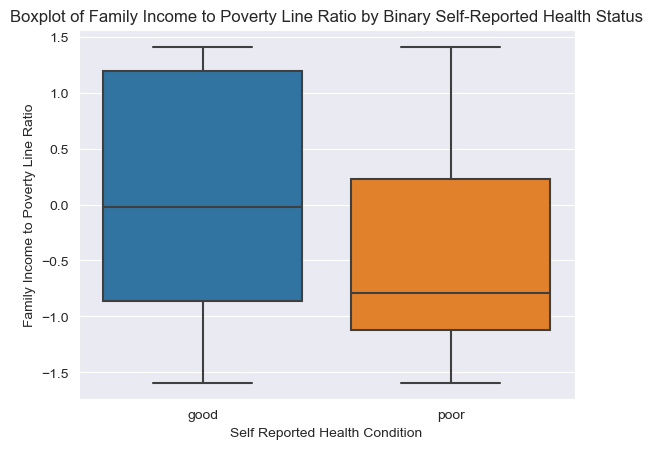

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

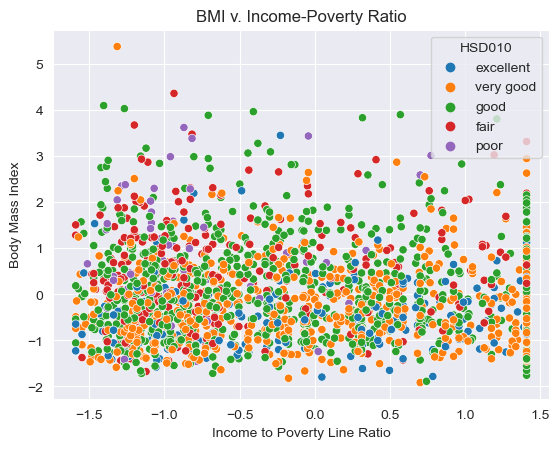

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
# nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1) i think this will make the training easier 

In [7]:
nhanes_scaled_unsupervised = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Answer 
**Number of components**

**Scatterplot**


### Train PCA and Discuss Number of Components

In [ ]:
## Your Answer Here

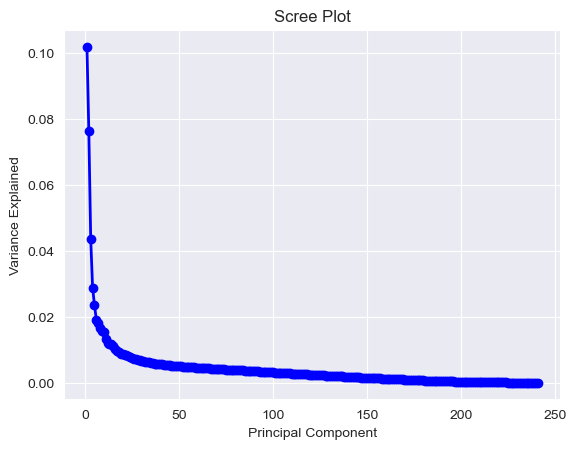

In [8]:
#
# Create a Scree plot to evaluate the number of components to keep
# --------------------------------------------------

# fit PCA
# ----------
pca_all = PCA() # notice we do not specify the number of components if we want to keep them all
principalComponents_breast = pca_all.fit_transform(nhanes_scaled_unsupervised)


# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [9]:
# apply PCA
# ----------
pca = PCA(n_components=10)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled_unsupervised)

# is 4 right? baed on scree plot

##### option 1 for df 

In [ ]:
# convert into a dataframe
# ----------
#pca_df = pd.DataFrame(data = principalComponents_nhanes, 
#                      columns = ['principal component 1', 
                                 'principal component 2',
                                 'principal component 3', 
                                 'principal component 4',
                                 'principal component 5', 
                                 'principal component 6',
                                 'principal component 7', 
                                 'principal component 8',
                                 'principal component 9', 
                                 'principal component 10'])

##### option 2 for df - this works 

In [10]:
pca_df = pd.DataFrame(data = principalComponents_nhanes, index=nhanes_scaled_unsupervised.index)  

In [11]:
# view factor loadings as dataframe
pca_df.head()

,0,1,2,3,4,5,6,7,8,9
SEQN,,,,,,,,,,
73568,9.527811,-0.816224,-1.867091,-2.110114,-3.929170,-0.181001,-3.847891,-2.928479,1.497428,0.675409
73576,-5.838339,-3.692573,3.805751,-1.030267,0.395177,1.604254,2.705868,-0.744300,0.375372,-2.433327
73579,-0.719454,-2.573201,0.907913,-4.756521,-1.798183,0.873115,-1.030964,0.645612,0.497901,0.414768
73581,3.533627,-2.576982,-3.249129,-0.405382,3.999171,1.444704,-1.176590,0.320842,-4.130861,-1.235753
73584,-6.872094,-4.194241,0.886839,-0.849168,-0.525859,0.072591,0.840902,0.999742,0.525394,-0.061132


#### Option 1: Examining the components

In [ ]:
# Example: accessing and printing some attributes
components = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_
mean = pca.mean_

print("Principal Components:")
print(components)
print("\nExplained Variance Ratio:")
print(explained_variance_ratio)
print("\nSingular Values:")
print(singular_values)
print("\nMean:")
print(mean)

#### Option 2: Examining the components

In [ ]:
# feature df
original_feature_names = nhanes_scaled_unsupervised.columns
components_df = pd.DataFrame(data=pca.components_, columns=original_feature_names)

# Display the components
#print("Principal Components:")
#print(components_df)
components_df

### Barplot of Components

In [ ]:
## Your Answer Here

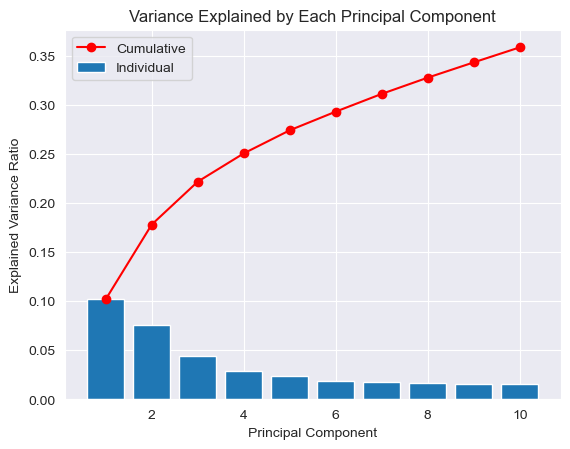

In [12]:
# Plot the explained variance ratio
# ----------
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Bar plot
fig, ax = plt.subplots()
ax.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, label='Individual')
ax.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, label='Cumulative', marker='o', color='r')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Variance Explained by Each Principal Component')
ax.legend()
plt.show()

### How many components will you use to fit a supervised learning model?

In [ ]:
## Your Answer Here

In [ ]:
# could i use another model besides logit?

In [ ]:
## I dont think i need this 
# Merge datasets on the variable SEQN
nhanes_scaled_supervised = pd.merge(nhanes_scaled, pca_df, on='SEQN')
nhanes_scaled_supervised.head()

In [ ]:
#pca_df['HSD010'] = nhanes_scaled['HSD010']
#pca_df.head()

##### option 1 for training

In [ ]:
#
# using PCA Features
# --------------------------------------------------------


# create target dataset
# ----------
y = nhanes_scaled['HSD010']


# create features dataset 
# ----------
X = pca_df


# split data
# ----------
X_train, X_test, y_train, y_test = train_test_split(X,                # specify features
                                                    y,                # specify labels
                                                    train_size = .80, # specify training data
                                                    test_size=0.20,   # specify test data
                                                    random_state=10)  # set seed

# initalize a logistic regresssion model
# ----------
logit_reg = LogisticRegression(max_iter= 5000) 


# fit the model
# ----------
logit_model = logit_reg.fit(X_train, 
                            y_train)

# predict on test set
# ----------
y_pred = logit_model.predict(X_test)

#### option 2 for training

In [13]:
#
# using PCA Features
# --------------------------------------------------------


# create target dataset
# ----------
y = nhanes_scaled['HSD010']


# create features dataset 
# ----------
X = pca_df


# split data
# ----------
X_train, X_test, y_train, y_test = train_test_split(X,                # specify features
                                                    y,                # specify labels
                                                    train_size = .80, # specify training data
                                                    test_size=0.20,   # specify test data
                                                    random_state=10)  # set seed

# initalize a logistic regresssion model
# ----------
logit_reg = LogisticRegression(max_iter= 5000) 


# fit the model
# ----------
logit_model = logit_reg.fit(X_train, 
                            y_train)


In [14]:
param_grid = {'penalty': ['l1','l2'],
              'C': np.arange(.1, 1, .1),
               'fit_intercept': [True, False],
             'solver': ['liblinear', 'saga']}

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
# execute the grid search and fit to training data
logit_grid = GridSearchCV(logit_model, 
                          param_grid, 
                          cv=3)


In [18]:
logit_grid.fit(X_train, 
              y_train)


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=5000),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

In [19]:
# choose best performing model
best_index = np.argmax(logit_grid.cv_results_["mean_test_score"])
best_logit_pred = logit_grid.best_estimator_.predict(X_test)

In [20]:
logit_grid_model = logit_grid.best_estimator_

In [21]:
y_pred = logit_grid_model.predict(X) # do i predict on X or x test?

#### option 1 to evaluate model

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the evaluation metrics
print(f'Accuracy: {accuracy:.4f}\n')
print(f'Confusion Matrix:\n{conf_matrix}\n')

#### option 2 to evaluate model 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# y and x
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Calculate the confusion matrix
unique_classes = np.unique(np.concatenate([y_test, y_pred]))
conf_matrix = np.zeros((len(unique_classes), len(unique_classes)))

for i in range(len(unique_classes)):
    for j in range(len(unique_classes)):
        conf_matrix[i, j] = np.sum((y_test == unique_classes[i]) & (y_pred == unique_classes[j]))

# Display accuracy
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
print(f'Accuracy: {accuracy:.4f}\n')

# Display the confusion matrix
print(f'Confusion Matrix:\n{conf_matrix}\n')

# Plot the confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

### 2D Scatterplot of the first two components

In [ ]:
## Your Answer Here

In [ ]:
## HSD010 is categorical but plot is only showing 2 outcomes

In [ ]:
# plot
# ----------

# figure settings
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Self-Reported Health",fontsize=20)
targets = ['excellent', 'very good', 'good', 'fair', 'poor']
colors = ['thistle', 'lavender']

# loop over targets and colors to create scatterplot
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['HSD010'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 0]
               , pca_df.loc[indicesToKeep, 1], c = color, s = 50)

# show figure
plt.legend(targets,prop={'size': 15})
plt.show();

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Answer 
**Clustering**
We learned about three types of clustering. I am testing out both k-means and hierarchical clustering. 

The k-means algorithm identifies clusters by:
1. Randomly assigning cases to pre-selected number of clusters; and 
2. Repeatedly calculating the centroid of the clusters and re-assigning each case to its nearest centroid until the clusters are stable. 

Hierarchical clustering includes top down and bottom up. The agglomerative clustering algorithm creates a cluster for each point and fuses that cluster to the nearest point until. This process continues until it reaches the pre-selected number of clusters. 

**Choices**
I chose the number of clusters based on the number of outcomes of my label, which is 5. 

**Scatterplot**

**Results of training**



### Choose a Clustering Algorithm

In [ ]:
## Your Answer Here

#### option 1 - k means

In [23]:
# set random seed
np.random.seed(10)

In [24]:
# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=5,
                n_init=10,
                max_iter=300 #default
                ).fit(nhanes_scaled_unsupervised)

In [25]:
# Get the cluster labels assigned to each data point
labels = kmeans.labels_
labels

array([3, 4, 4, ..., 4, 3, 1], dtype=int32)

In [26]:
## creating the centers
centers = pd.DataFrame(kmeans.cluster_centers_, columns=nhanes_scaled_unsupervised.columns)
centers

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
0,0.0,-0.056022,0.0,-0.090597,-0.086534,-0.085268,0.174538,-0.019197,0.055250,-0.077377,...,0.285045,-0.563515,0.583464,-0.466246,0.212611,0.0,-0.223277,0.050646,0.359797,0.496488
1,0.0,0.045388,0.0,0.065884,-0.024897,0.003134,-0.083808,-0.057306,0.093209,-0.067526,...,-0.235532,0.237586,-0.240271,-0.324859,-0.388147,0.0,0.233230,-0.096350,-0.196238,0.316531
2,0.0,-0.104857,0.0,0.139618,-0.000594,-0.210264,0.174279,0.100462,-0.031700,-0.042636,...,1.180823,-0.531293,0.659029,-0.484200,0.330411,0.0,-0.286488,0.295245,0.324317,0.612440
3,0.0,0.007267,0.0,0.023396,0.164395,0.008725,0.006988,0.022210,0.006894,-0.023726,...,-0.114360,0.136116,-0.149236,-0.032581,-0.146620,0.0,-0.024705,-0.002389,-0.094517,-0.022645
4,0.0,0.008222,0.0,-0.095331,-0.005588,0.152772,-0.100581,0.068675,-0.221953,0.240083,...,-0.201563,0.236182,-0.287310,1.284686,0.488519,0.0,-0.063656,0.016725,-0.057867,-1.300182


In [27]:
## adding the label 
nhanes_scaled_kmeans = nhanes_scaled.assign(label = kmeans.labels_.astype(str))

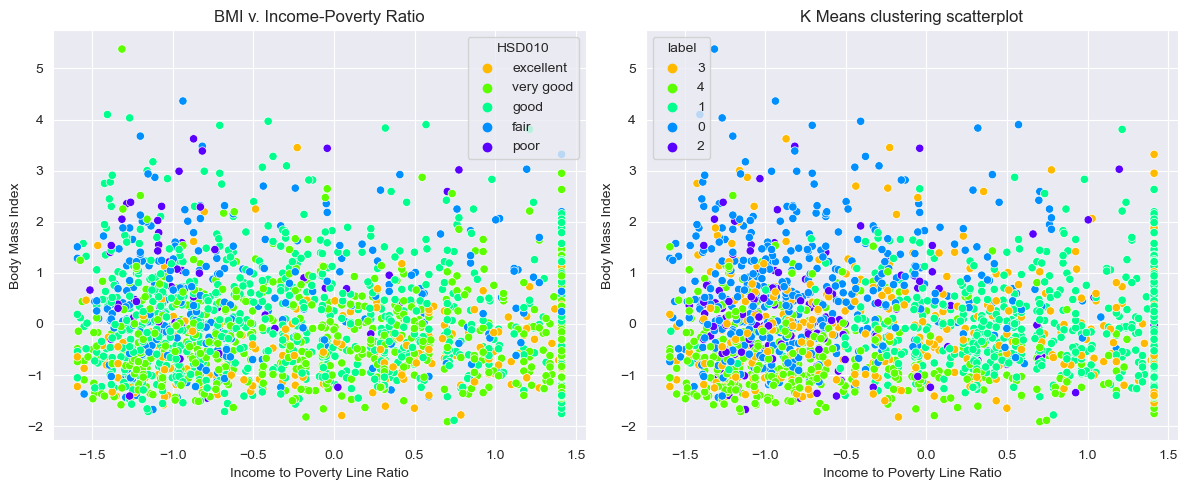

In [28]:
# Set up the figure and axes for two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1
sns.scatterplot(x="INDFMPIR", y="BMXBMI", hue="HSD010", palette="gist_rainbow", data=nhanes_scaled, ax=axes[0])
axes[0].set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
axes[0].set_title("BMI v. Income-Poverty Ratio")

# Plot 2
sns.scatterplot(x="INDFMPIR", y="BMXBMI", hue="label", palette="gist_rainbow", data=nhanes_scaled_kmeans, ax=axes[1])
axes[1].set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
axes[1].set_title("K Means clustering scatterplot")

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()

#### option 2 - agglomerative 

In [29]:
from sklearn.cluster import AgglomerativeClustering

In [30]:
# run algorithm
# ----------
ward = AgglomerativeClustering(n_clusters=5,
                               linkage='ward', #linkage can be ward (default), complete, or average
                               metric='euclidean') #affinity must be euclidean if linkage=ward

In [31]:
# fit to data 
# ----------
ward.fit(nhanes_scaled_unsupervised)

AgglomerativeClustering(metric='euclidean', n_clusters=5)

In [32]:
## adding the label 
nhanes_scaled_agglomerative = nhanes_scaled.assign(label = ward.labels_.astype(str))

#### Is this plot right?

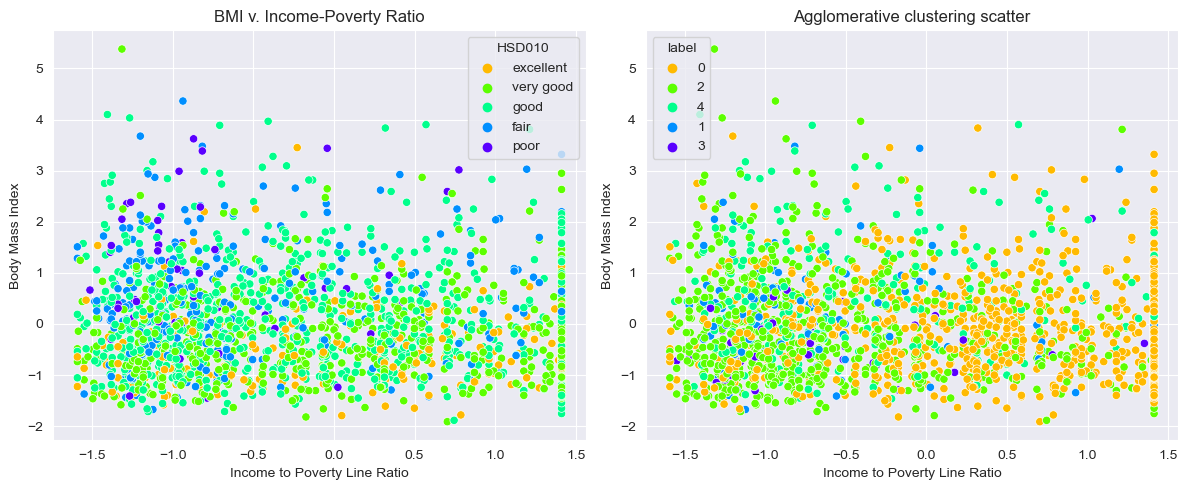

In [33]:
# Set up the figure and axes for two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1
sns.scatterplot(x="INDFMPIR", y="BMXBMI", hue="HSD010", palette="gist_rainbow", data=nhanes_scaled, ax=axes[0])
axes[0].set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
axes[0].set_title("BMI v. Income-Poverty Ratio")

# Plot 2
sns.scatterplot(x="INDFMPIR", y="BMXBMI", hue="label", palette="gist_rainbow", data=nhanes_scaled_agglomerative, ax=axes[1])
axes[1].set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
axes[1].set_title("Agglomerative clustering scatter")

# format
plt.tight_layout()

plt.show()

### Cluster nhanes

In [ ]:
## Your Answer Here

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [ ]:
## Your Answer Here

## Your Answer Here

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [42]:
# this is wrong

In [45]:
## dropping the outcome
#pca_df = pca_df.drop(columns=['HSD010'])
pca_df

,0,1,2,3,4,5,6,7,8,9
SEQN,,,,,,,,,,
73568,9.527811,-0.816224,-1.867091,-2.110114,-3.929170,-0.181001,-3.847891,-2.928479,1.497428,0.675409
73576,-5.838339,-3.692573,3.805751,-1.030267,0.395177,1.604254,2.705868,-0.744300,0.375372,-2.433327
73579,-0.719454,-2.573201,0.907913,-4.756521,-1.798183,0.873115,-1.030964,0.645612,0.497901,0.414768
73581,3.533627,-2.576982,-3.249129,-0.405382,3.999171,1.444704,-1.176590,0.320842,-4.130861,-1.235753
73584,-6.872094,-4.194241,0.886839,-0.849168,-0.525859,0.072591,0.840902,0.999742,0.525394,-0.061132
...,...,...,...,...,...,...,...,...,...,...
83694,2.643319,-1.689356,-0.702597,-0.538186,-1.021910,-0.674891,0.474637,-0.297482,0.973649,-1.231771
83696,1.037906,-0.118065,5.556458,1.630048,0.968116,1.146718,1.951216,0.920373,-1.270225,-2.010565
83704,1.130253,-0.970432,3.415398,1.206266,-3.632468,1.130387,1.357223,1.817933,-2.357246,0.178883


In [46]:
# set random seed
np.random.seed(10)

In [47]:
# specify kmeans algorithm
# ----------
kmeans_pca = KMeans(n_clusters=5,
                n_init=10,
                max_iter=300 #default
                ).fit(pca_df)

In [39]:
## adding the label 
nhanes_scaled_kmeans_pca = nhanes_scaled.assign(label = kmeans_pca.labels_.astype(str))

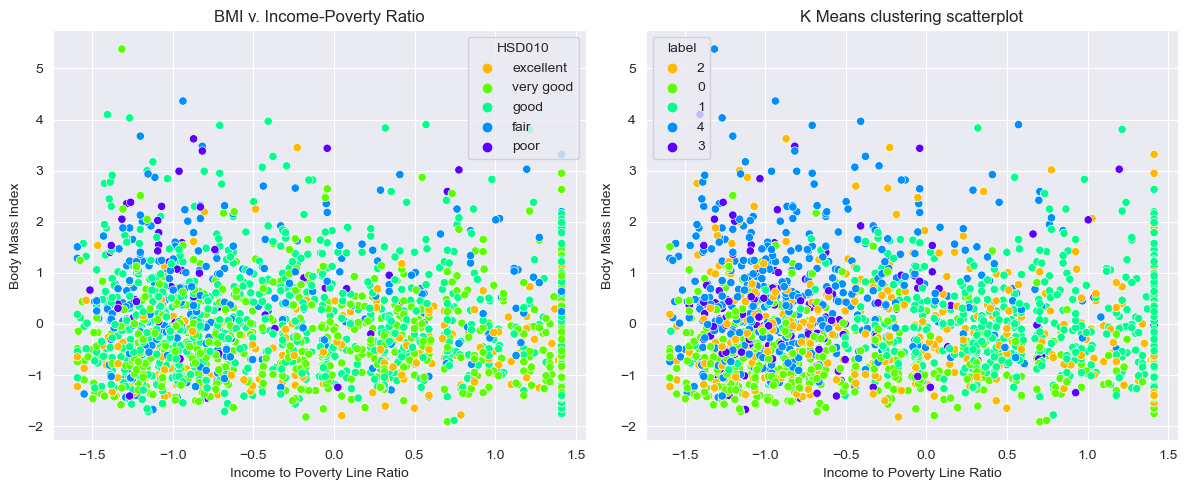

In [40]:
# Set up the figure and axes for two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1
sns.scatterplot(x="INDFMPIR", y="BMXBMI", hue="HSD010", palette="gist_rainbow", data=nhanes_scaled, ax=axes[0])
axes[0].set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
axes[0].set_title("BMI v. Income-Poverty Ratio")

# Plot 2
sns.scatterplot(x="INDFMPIR", y="BMXBMI", hue="label", palette="gist_rainbow", data=nhanes_scaled_kmeans_pca, ax=axes[1])
axes[1].set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
axes[1].set_title("K Means clustering scatterplot")

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()

## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [ ]:
# partition data
# -----------
y = ... # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = ... # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [ ]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = ...
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(..., ...)
y_test = keras.utils.to_categorical(..., ...)
num_classes = y_test.shape[1]

In [ ]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(..., input_dim= ..., kernel_initializer= ..., activation= ...))

model.add(Dense(..., kernel_initializer= ..., activation= ...))

## Add any additional layers you wish here

model.compile(loss= ..., optimizer= ..., metrics=[...])

model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=...)

### Neural Network on Principal Components

In [ ]:
## Your Answer Here

### Neural Network on Principal Components + Cluster Membership

In [ ]:
## Your Answer Here

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"